In [1]:
import numpy as np 
import pickle
import os

In [2]:



def read_pickle(filepath):
    # Open the pickle file in read-binary mode
    with open(filepath, 'rb') as f:
        # Load the object from the file using pickle.load()
        data = pickle.load(f)
    return data



In [20]:
results_dir = "../fl_results/result_FEMNIST_balanced5000/"


fed_filepath = os.path.join(results_dir, "col_performance.pkl")
fed_data = read_pickle(fed_filepath)
# print("average: {0}".format(np.mean([fed_data[i][-1] for i in range(len(fed_data))])))

fedmd = np.zeros((len(fed_data), len(fed_data[0])))
for i, item  in enumerate(fed_data.items()):
    k, v = item
    fedmd[i] = v
fedmd_avg = np.mean(fedmd, axis = 0)
fedmd_std = np.std(fedmd, axis = 0)


client: 0.683
client: 0.688
client: 0.6658333333333334
client: 0.6933333333333334
client: 0.6671666666666667
client: 0.6696666666666666
client: 0.6333333333333333
client: 0.6926666666666667
client: 0.6251666666666666
client: 0.6266666666666667

client: 0.6826666666666666
client: 0.633
client: 0.704
client: 0.695
client: 0.6748333333333333
client: 0.6946666666666667
client: 0.658
client: 0.6883333333333334
client: 0.5913333333333334
client: 0.6781666666666667



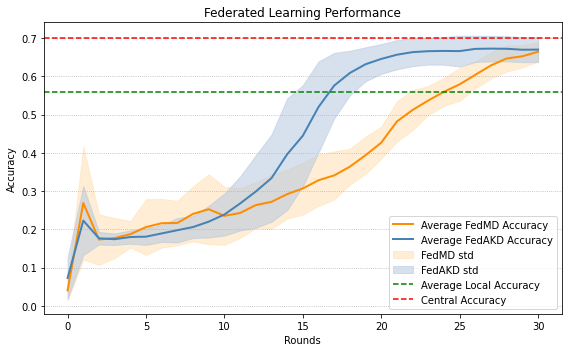

In [33]:
# import plt 
import matplotlib.pyplot as plt
import numpy as np

results_dir = "../fl_results/result_FEMNIST_balanced5000/"


fed_filepath = os.path.join(results_dir, "col_performance.pkl")
fed_data = read_pickle(fed_filepath)
# print("average: {0}".format(np.mean([fed_data[i][-1] for i in range(len(fed_data))])))

fedmd = np.zeros((len(fed_data), len(fed_data[0])))
for i, item  in enumerate(fed_data.items()):
    k, v = item
    fedmd[i] = v
    print("client:", v[-1])
print()
fedmd_avg = np.mean(fedmd, axis = 0)
fedmd_std = np.std(fedmd, axis = 0)



results_dir = "../fl_results/result_FEMNIST_balanced5000_aug/"
fed_filepath = os.path.join(results_dir, "col_performance.pkl")
fed_data_aug = read_pickle(fed_filepath)

fedakd = np.zeros((len(fed_data_aug), len(fed_data_aug[0])))
for i, item  in enumerate(fed_data_aug.items()):
    k, v = item
    fedakd[i] = v
    print("client:", v[-1])
print()
fedakd_avg = np.mean(fedakd, axis = 0)
fedakd_std = np.std(fedakd, axis = 0)


results_dir = "../fl_results/result_FEMNIST_balanced1000_aug_compress/"
fed_filepath = os.path.join(results_dir, "col_performance.pkl")
fed_data_aug = read_pickle(fed_filepath)

fedakd = np.zeros((len(fed_data_aug), len(fed_data_aug[0])))
for i, item  in enumerate(fed_data_aug.items()):
    k, v = item
    fedakd[i] = v
    print("client:", v[-1])
print()
fedakd_avg = np.mean(fedakd, axis = 0)
fedakd_std = np.std(fedakd, axis = 0)

# results_dir = "../fl_results/result_FEMNIST_balanced5000_aug_compress/"
# fed_filepath = os.path.join(results_dir, "col_performance.pkl")
# fed_data_aug_compress = read_pickle(fed_filepath)

# fedakd_cmp = np.zeros((len(fed_data_aug_compress), len(fed_data_aug_compress[0])))
# for i, item  in enumerate(fed_data_aug_compress.items()):
#     k, v = item
#     fedakd_cmp[i] = v
#     print("client:", v[-1])
# print()
# fedakd_cmp_avg = np.mean(fedakd, axis = 0)
# fedakd_cmp_std = np.std(fedakd, axis = 0)



fig, ax = plt.subplots(figsize=(8, 5))

# Plot the average values as a line
ax.plot(fedmd_avg, color='darkorange', label='Average FedMD Accuracy', linewidth=2)
ax.plot(fedakd_avg, color='steelblue', label='Average FedAKD Accuracy', linewidth=2)
# ax.plot(fedakd_cmp_avg, color='red', label='Average CFedAKD Accuracy', linewidth=2)

# Plot the standard deviation as a shaded region
ax.fill_between(range(len(fedmd_avg)), fedmd_avg - fedmd_std, fedmd_avg + fedmd_std, color = 'navajowhite', alpha=0.5, label='FedMD std')
ax.fill_between(range(len(fedakd_avg)), fedakd_avg - fedakd_std, fedakd_avg + fedakd_std, color = 'lightsteelblue', alpha=0.5, label='FedAKD std')
# ax.fill_between(range(len(fedakd_cmp_avg)), fedakd_cmp_avg - fedakd_cmp_std, fedakd_cmp_avg + fedakd_cmp_std, color = 'lightcoral', alpha=0.5, label='CFedAKD std')


ax.axhline(y=0.56, color='green', linestyle='--', label='Average Local Accuracy')
ax.axhline(y=0.7, color='red', linestyle='--', label='Central Accuracy')

# Set x and y axis labels and title
ax.set_xlabel('Rounds')
ax.set_ylabel('Accuracy')
ax.set_title('Federated Learning Performance')
ax.legend(loc='lower right')

# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as a high-quality PDF
plt.savefig('fedakd.pdf', dpi=300)


average: 0.6373


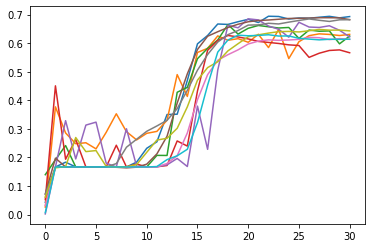

In [11]:
# import plt 
import matplotlib.pyplot as plt
import numpy as np

results_dir = "../fl_results/result_FEMNIST_balanced5000_aug_compress/"


fed_filepath = os.path.join(results_dir, "col_performance.pkl")
fed_data_aug = read_pickle(fed_filepath)
print("average: {0}".format(np.mean([fed_data_aug[i][-1] for i in range(len(fed_data_aug))]  )))

for k, v  in fed_data_aug.items():
    plt.plot(fed_data_aug[k])

# avg_FedMD_acc = np.mean([fed_data[i][-1] for i in range(len(fed_data))])
# print("AVG:: f:{0}".format(avg_FedMD_acc))
# for i in range(len(local_accs)):
#     # print("local acc: {0}, central acc: {1}".format(local_accs[i], central_accs[i]))
#     print("Local acc: {0}".format(local_accs[i]))
#     print("Central acc: {0}".format(central_accs[i]))
#     print("FedMD acc: {0}".format(fed_data[i][-1]))
#     print() 
